## Project: Influence of hurricane Sandy

## Hypothesis
- H1: Cancellation and delays appeared parallel to the hurricane path.
- H2: There is a threshold (wind, rain, fog) until the flights are not cancelled. (Sergej)
- H3: Many delays up to two weeks after the hurricane.

- H4 Diverted flights with destination choosen airports (Sergej)
 s
## Show the course of hurricane Sandy
- Add image from Sandy to the notebook https://www.tableau.com/solutions/gallery/storm-tracking
- Mark the airports with dates


# Step 1: Get data
- get flights data
- get weather data

# Step 2: EDA
		cancelled
		delays
		diverted
- Add dates of hurricane Sandy: 

# Step 3: Visualization 


## Questions to answer and plot 
- Diverted flights with destination of the airports:
    - Boston (BOS)
	- Miami (MIA)
	- Newark (EWR)
	- New York (JFK)
	- Philadelphia (PHL)
	- Purto Rico (SJU)

In [31]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2
import requests #package for getting data from the web
from zipfile import * #package for unzipping zip files
from sql import get_engine #adjust this as necessary to match your sql.py connection methods

In [32]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [33]:
years = [2011, 2012] # list of years you want to look at, specify one year
months = [10, 11, 12] # list of months you want to look at, specify one month
# Here: October, November, October 2011 and 2012 / 1 file ca. 23 mb

# Loop through months
for year in years:
    for month in months:
        # Get the file from the website https://transtats.bts.gov
        zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        csv_file = f'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv'
        url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
        # Download the database
        # r = requests.get(f'{url}', verify=False)
        # Save database to local file storage
        with open(path+zip_file, 'wb') as f:
            f.write(r.content)

In [34]:
# Unzip your files 220 Mb / per file
for year in years:
    for month in months:
        zip_files = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
        with ZipFile(path+zip_files, 'r') as zip_ref:
            zip_ref.extractall(path)

In [30]:
# Read in your data DOESNT WORK YET
# df = pd.DataFrame(data=None)
# for year in years:
#     for month in months:
#         appended_flights = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_{year}_{month}.csv', low_memory = False)
#         df.append(appended_flights)

SyntaxError: 'return' outside function (3463468356.py, line 7)

In [35]:
# Read in your data
flights_df_2011_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_10.csv', low_memory = False)
flights_df_2011_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_11.csv', low_memory = False)
flights_df_2011_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2011_12.csv', low_memory = False)
flights_df_2012_10 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_10.csv', low_memory = False)
flights_df_2012_11 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_11.csv', low_memory = False)
flights_df_2012_12 = pd.read_csv(f'data/On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2012_12.csv', low_memory = False)
# Combine your date, use a function
flights_df1 = flights_df_2011_10.append(flights_df_2011_11)
flights_df2 = flights_df1.append(flights_df_2011_12)
flights_df3 = flights_df2.append(flights_df_2012_10)
flights_df4 = flights_df3.append(flights_df_2012_11)
df = flights_df4.append(flights_df_2012_12)

# 2. Prepare the csv file for further processing

In the next step, we clean and prepare our dataset.

a) Since the dataset consists of a lot of columns, we we define which ones to keep.

In [36]:
# Columns from downloaded file that are to be kept

columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [37]:
# set up your database connection
engine = get_engine()

In [38]:
# The columns in the DB have different naming as in the source csv files. Lets get the names from the DB
table_name_sql = '''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='public'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [39]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'distance',
 'cancelled',
 'diverted']

In [43]:
# Just in case the above fails here are the results
new_column_names_alternate = ['flight_date',
                              'dep_time',
                              'sched_dep_time',
                              'dep_delay',
                              'arr_time',
                              'sched_arr_time',
                              'arr_delay',
                              'airline',
                              'tail_number',
                              'flight_number',
                              'origin',
                              'dest',
                              'air_time',
                              'distance',
                              'cancelled',
                              'diverted' ]

b) With the next function, we make our csv file ready to be uploaded to SQL.  
We only keep to above specified columns and convert the datatypes.

In [46]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [47]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


If you decide to only look at specific airports, it is a good decision to filter for them in advance.  
This function does the filtering. 

In [48]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering airline df for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [49]:
# Execute function, filtering for New York area airports
airports=['BOS', 'EWR', 'JFK', 'MIA', 'PHI', 'SJU']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10-01,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10-02,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10-03,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10-04,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10-05,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0


# 3. Push the prepared data to a table in the database

In [50]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table
table_name = 'group4_flights_data'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This will take a minute or two...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

In [ ]:
# Check the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

# Get weather_data with API

In [ ]:
# import python packages 
from meteostat import Point, Stations, Daily
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from IPython.display import display

# import from own modules
import sql as gd
import api

# change options
pd.set_option('display.max_columns', None)
"""
https://github.com/python-pillow/Pillow/issues/5257
"""

In [ ]:
us_stations_df = pd.read_csv('data/us_weather_stations.csv')

# from: https://www.faa.gov/airports/airport_safety/airportdata_5010/menu/#datadownloads
airports_df = pd.read_csv('data/NfdcFacilities.csv', sep=';')

# keep needed columns
airports_df = airports_df[['Type', 'LocationID', 'Region', 'City', 'CountyState', 'IcaoIdentifier']] 

# clean data and rename columns
def clean_data(df):
    df['LocationID'] = [string.strip("'") for string in df['LocationID']]
    df.columns = [col.replace(col, col.lower()) for col in df.columns]

clean_data(airports_df)

# change 'locationid' to 'faa' to match the column name in flights_df 
    # and 'icaoidentifier' to 'icao' to match the column name in weather_df
airports_df.rename(columns={'locationid': 'faa', 'icaoidentifier': 'icao'}, inplace=True)

# filter only rows of the 6 airports we are interested in
locations = airports_df[airports_df['faa'].isin(['BOS', 'EWR', 'JFK', 'MIA', 'PHL', 'SJU'])]

# create a list of icao ids of the location to pass to the API
icao_list = locations['icao'].tolist()

In [ ]:
# get all weather stations in us and puerto rico
# api.get_weather_stations('PR', 'data/pr_weather_stations.csv')

In [ ]:
# find the weather stations near the 6 relevant airports
us_stations_df = pd.read_csv('data/us_weather_stations.csv')

# create dataframe of weather stations in Puerto Rico
pr_stations_df = pd.read_csv('data/pr_weather_stations.csv')

# create a dataframe of all weather stations in US and Puerto Rico
all_weather_stations_df = pd.concat([us_stations_df, pr_stations_df], axis=0)

# filter dataframe on the icao identifiers of the 6 airports
weather_stations_df = all_weather_stations_df[all_weather_stations_df['icao'].isin(icao_list)]
display(weather_stations_df)

In [ ]:
# create a list of the weather station ids to pass to the api
# weather_stations_list = weather_stations_df['id'].tolist()
# display(weather_stations_list)

In [ ]:
# start = datetime(2012, 10, 15)
# end = datetime(2012, 10, 15)
# id = '72202' # station id?

# data = Daily(id, start, end) 
# data = data.fetch()

# display(data)
#sj_id = data.to_csv('data/sj_id.csv')

In [ ]:
# start = datetime(2012, 10, 15)
# end = datetime(2012, 10, 15)
# point_sj = Point(18.4333, -66, 9)

# data = Daily(point_sj, start, end) 
# data = data.fetch()

# display(data)
# sj_point = data.to_csv('data/sj_point.csv')

# --> different data is returned, depending if the id is used 
    # or a point is created by using the lat and lon values connected to that id
    # I am going to use the lat and lon values due to this issue

In [ ]:
# in order to use lat and lon values I am going to create a dictionary with:
    # key = icao
    # values = latitude, longitude
stations_dict = dict()
for i in range(len(weather_stations_df)):
    key = weather_stations_df['icao'].iloc[i]
    stations_dict[key] = weather_stations_df['latitude'].iloc[i], weather_stations_df['longitude'].iloc[i]
    
display(stations_dict)

In [ ]:
# start = dt.datetime(2012, 10, 1)
# end = dt.datetime(2012, 12, 31) 
# api.get_weather_daily(stations_dict, start, end, 'data/weather_4quarter.csv')

In [ ]:
# start = dt.datetime(2011, 10, 1)
# end = dt.datetime(2011, 12, 31) 
# api.get_weather_daily(stations_dict, start, end, 'data/weather_2011_4quarter.csv')

In [ ]:
# Code	Meaning
# TEMP	Air Temperature
# TAVG	Average Temperature
# TMIN	Minimum Temperature
# TMAX	Maximum Temperature
# DWPT	Dew Point
# PRCP	Total Precipitation
# WDIR	Wind Direction
# WSPD	Average Wind Speed
# WPGT	Wind Peak Gust
# RHUM	Relative Humidity
# PRES	Sea-Level Air Pressure
# SNOW	Snow Depth
# TSUN	Total Sunshine Duration
# COCO	Weather Condition Code
# #

In [ ]:
# create a dataframe with the weather data
weather_df_2011 = pd.read_csv('data/weather_2011_4quarter.csv')
weather_df_2012 = pd.read_csv('data/weather_2012_4quarter.csv')

# change time column to datatime data type
weather_df_2011['time'] = pd.to_datetime(weather_df_2011['time'])
weather_df_2012['time'] = pd.to_datetime(weather_df_2012['time'])

# drop the empty column wpgt
weather_df_2011.drop('wpgt', axis=1, inplace=True)
weather_df_2012.drop('wpgt', axis=1, inplace=True)

# create weather_df to upload the data of both years in one file
weather_df = pd.concat([weather_df_2011, weather_df_2012], axis=0)

display(weather_df_2011.head(2))
display(weather_df_2012.head(2))

In [ ]:
# add an additional column with the 'icaoidentifier' to the weather df
weather_df = weather_df.merge(locations[['icao', 'faa']], how='left', on='icao')

# move 'faa' column to the first 2 position
weather_df = weather_df[['time', 'icao', 'faa', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir',
       'wspd', 'pres', 'tsun']]

In [ ]:
# save weather data to database
table_name = 'group4_weather_data'
gd.save_to_db(weather_df, table_name)

In [ ]:
# get the flights data from database
flights_df = gd.query_database("SELECT * FROM public.group4_flights_data")


display(type(flights_df))
display(flights_df.head(5))
display(flights_df.info())

In [ ]:
weather_df_2011.drop('date', axis=1, inplace=True)

In [ ]:
weather_df_2011['date'] = weather_df_2011['time'].apply(lambda x: x.strftime('D%-%B')) 
weather_df_2011

In [ ]:

time_axes = weather_df_2011['time'].dt.month.astype('str') + '-' + weather_df_2011['time'].dt.day.astype('str')

## EDA

In [ ]:
flights_data.groupby('flight_date')[['cancelled', 'diverted']].sum()

,cancelled,diverted
flight_date,,
2011-10,920.0,158.0
2011-11,333.0,113.0
2011-12,450.0,91.0
2012-10,5450.0,99.0
2012-11,1699.0,122.0
2012-12,975.0,146.0


In [ ]:
flights_data[['dep_delay', 'arr_delay']].head()

,dep_delay,arr_delay
0,-10.0,-64.0
1,-5.0,-47.0
2,-6.0,-54.0
3,-3.0,-16.0
4,-9.0,-21.0


<AxesSubplot:xlabel='flight_date'>

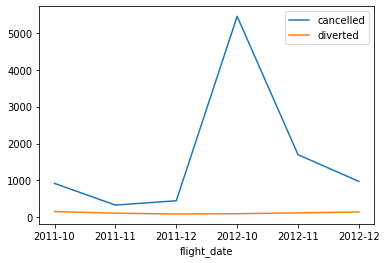

In [161]:
flights_data.groupby('flight_date')[['cancelled', 'diverted']].sum().plot()

In [ ]:
flights_data.groupby('flight_date')[['dep_delay', 'arr_delay']].mean()

,dep_delay,arr_delay
flight_date,,
2011-10,8.216126,3.929782
2011-11,6.021246,-0.274453
2011-12,8.309443,1.437750
2012-10,9.665390,5.113147
2012-11,7.589444,0.269191
2012-12,13.570076,8.529034


In [159]:
flights_data.head(20)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,distance,cancelled,diverted
0,2011-10,850.0,900,-10.0,1103.0,1207,-64.0,AA,N320AA,1,JFK,LAX,295.0,2475.0,0,0
1,2011-10,855.0,900,-5.0,1120.0,1207,-47.0,AA,N327AA,1,JFK,LAX,294.0,2475.0,0,0
2,2011-10,854.0,900,-6.0,1113.0,1207,-54.0,AA,N339AA,1,JFK,LAX,294.0,2475.0,0,0
3,2011-10,857.0,900,-3.0,1151.0,1207,-16.0,AA,N323AA,1,JFK,LAX,309.0,2475.0,0,0
4,2011-10,851.0,900,-9.0,1146.0,1207,-21.0,AA,N328AA,1,JFK,LAX,333.0,2475.0,0,0
5,2011-10,850.0,900,-10.0,1145.0,1207,-22.0,AA,N327AA,1,JFK,LAX,334.0,2475.0,0,0
6,2011-10,852.0,900,-8.0,1138.0,1207,-29.0,AA,N319AA,1,JFK,LAX,315.0,2475.0,0,0
7,2011-10,859.0,900,-1.0,1140.0,1207,-27.0,AA,N338AA,1,JFK,LAX,309.0,2475.0,0,0
8,2011-10,852.0,900,-8.0,1136.0,1207,-31.0,AA,N332AA,1,JFK,LAX,299.0,2475.0,0,0
9,2011-10,854.0,900,-6.0,1116.0,1207,-51.0,AA,N339AA,1,JFK,LAX,302.0,2475.0,0,0


In [160]:
flights_data[flights_data['cancelled'] == 0 ].groupby('flight_date').agg({'dep_delay': ['mean', 'min', 'max']})

dep_delay              
                  mean   min     max
flight_date                         
2011-10       8.203569 -23.0   667.0
2011-11       6.017718 -28.0  1445.0
2011-12       8.299912 -26.0   981.0
2012-10       9.648733 -28.0   923.0
2012-11       7.568044 -29.0  1255.0
2012-12      13.540890 -37.0  1385.0

## VISU

In [ ]:

# time_axes = 
col_list = ['tavg', 'wspd', 'prcp']

for col in col_list:
    fig, ax = plt.subplots(figsize=(10,6))

    # x = 
    # y = 

    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2011[col], color='r', ci=None, ax=ax, label='2011')
    sns.lineplot(x=weather_df_2011['time'], y=weather_df_2012[col], color='b', ci=None, ax=ax, label='2012')
    
    ax.set_title(col.capitalize())
    #ax.legend()
    plt.show()

In [ ]:
column_list = weather_df.columns
for col in column_list[2:]:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

In [ ]:
# good to work with temperature and windspeed
# maybe perspiration

column_list = ['tavg', 'wspd', 'prcp']
for col in column_list:
    weather_df[weather_df['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)

In [ ]:
display(stations_dict)
# create a list of airports ordered by the course of the hurricane
ordered_airports = ['TJSJ', 'KMIA', 'KPHL', 'KJFK', 'KEWR', 'KBOS']

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='wspd', figsize=(8,6), rot=90)

In [ ]:
# plot only the average temperature for all airports
for airport in ordered_airports:
    weather_df[weather_df['icao'] == airport].plot(kind='line', x='time', y='prcp', figsize=(8,6), rot=90)

In [ ]:
# lets take a look at the weather_df from 20.10 - 5.11
weather_df_15 = weather_df[(weather_df['time'] >= '2012-10-20') & (weather_df['time'] <= '2012-11-5') ]

# and visualize again
column_list = weather_df_15.columns
for col in column_list[2:]:
    weather_df_15[weather_df_15['icao'] == 'TJSJ'].plot(kind='line', x='time', y=col, figsize=(8,6), rot=90)